In [1]:
dt_cckw_cross_hrs = 0 # THIS WILL BE USED FOR BOTH THE DEVELOPERS AND NON-DEVELOPERS (SEE NEXT CODE BLOCK) 
#time delta between crossing cckw and tropical wave position



In [2]:
# Parameters
dt_cckw_cross_hrs = 24


In [3]:
# Import relevant packages


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import random


2025-05-11 14:54:04.494473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#Load in time series data of equatorial wave developers/nondevs that interact with a cckw (generated from find_analyze_devs_and_nondevs.ipynb) 

eq_dv_updated = pd.read_csv('eq_dv_updated.csv') 
eq_ndv_updated = pd.read_csv('eq_ndv_updated.csv') 


In [5]:
#Ok great, it's 33 like we expect. Now let's generate histograms of time between CCKW crossing and tropical cyclogenesis - this should be a check to see if we're in the 1.5-3.5 day time frame as we expect 

eq_dv_updated_groupbyID = eq_dv_updated.groupby("ID")  # Group the 33 equatorial developers by ID

eq_dv_updated_groupbyID.head()



,ID,fhr,valid_time,lon_TRACK,lat_TRACK,vor850,day_adj,cckw_crest_cross,tc_genesis
0,139,18.0,2000-03-30 18:00:00,289.227661,12.518373,1.662696,1.25,0.0,0
1,139,24.0,2000-03-31 00:00:00,288.096191,12.066323,1.480228,1.50,0.0,0
2,139,30.0,2000-03-31 06:00:00,286.437073,11.456782,1.368978,1.75,0.0,0
3,139,36.0,2000-03-31 12:00:00,283.840454,10.344266,1.408606,2.00,0.0,0
4,139,42.0,2000-03-31 18:00:00,283.081482,10.036515,1.418872,2.25,0.0,0
...,...,...,...,...,...,...,...,...,...
1989,6471,3102.0,2000-08-06 06:00:00,133.723282,8.651182,1.112677,129.75,0.0,0
1990,6471,3108.0,2000-08-06 12:00:00,134.428024,8.390718,1.400240,130.00,0.0,0
1991,6471,3114.0,2000-08-06 18:00:00,136.860336,7.866118,2.337027,130.25,0.0,0
1992,6471,3120.0,2000-08-07 00:00:00,136.793060,7.560466,3.332326,130.50,0.0,0


In [6]:
all_days_tc_gen_after_cckw = []
days_tc_gen_after_cckw = []

for ID, group in eq_dv_updated_groupbyID:

    days = group['day_adj']
    cckw_crest_cross = group['cckw_crest_cross']
    tc_genesis = group['tc_genesis']

    idx_cckw_crest_cross = np.where(cckw_crest_cross == 1)[0]
    idx_tc_genesis = np.where(tc_genesis == 1)[0]

    idx_cckw_preceding_tcgen = idx_cckw_crest_cross[idx_cckw_crest_cross < idx_tc_genesis]

    #If multiple cckw crossings prior to tcgen find the last crossing before tcgen
    if idx_cckw_preceding_tcgen.size>0: 
        idx_cckw_preceding_tcgen = idx_cckw_preceding_tcgen[-1] 

    #hack if the developer never technically interacts with the cckw, set the first track pt to be interaction
    if idx_cckw_preceding_tcgen.size==0:
        
        days_tc_gen_after_cckw = idx_tc_genesis/4 #6hr resolution 

    else: 
        
        days_tc_gen_after_cckw = (idx_tc_genesis - idx_cckw_preceding_tcgen)/4 #6hr resolution 

    all_days_tc_gen_after_cckw.append(days_tc_gen_after_cckw.item())

Text(0, 0.5, 'Frequency')

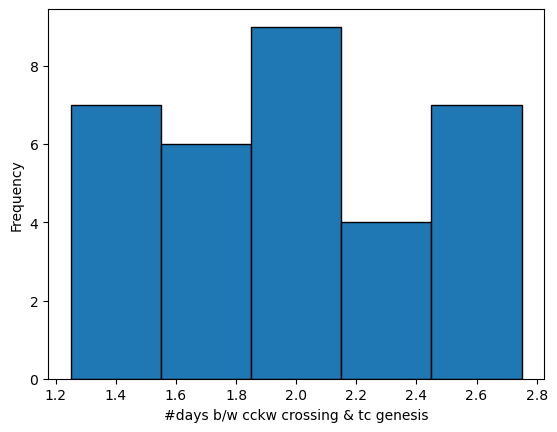

In [7]:
plt.hist(all_days_tc_gen_after_cckw, bins=5, edgecolor='black')
#These are a *hair* different than what Rosi got - but she's also doing it differently. 
#Maybe I should just have followed what she was doing....but go take a look later. 
#Does Rosi have a histogram of these values I can compare it to? 
plt.xlabel('#days b/w cckw crossing & tc genesis')
plt.ylabel('Frequency') 


In [8]:
#So outstanding problems thus far
#CCKW intersection algorithm for nondevelopers seems slightly off
#My algorithm I'm pretty sure isn't exactly what Rosi did - I should just replicate what she did - also some of my developers never "intersect" a wave but she found they did so there's a discrepancy somewhere 
#I don't know how Rosi generated her developers & nondevelopers, and it would be great to know that for my own benefit. 
#For my developers, they are slightly off in time I think compared to the established 1.5-3.5 day window. Again, I believe this to be an issue with the CCKW intersection algo
#Dealing with data truncation issues? For developers/nondevelopers, are we being consistent with keeping data within a certain latitude range from the equator? 
#General code cleanup 

In [9]:
#Work for AOSC650 - Can we predict whether TC genesis will occur based on the state of the tropical wave when it intersects with a CCKW? 

exp_name = 'TC_3km'
pth = "/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N/%s/"%exp_name
fname = pth+'latlon/diags_gaussian_global_nospinup_r3600x1800.nc'
ds = xr.open_dataset(fname)
ds

<xarray.Dataset> Size: 90GB
Dimensions:   (time: 538, lon: 3600, lat: 552)
Coordinates:
  * time      (time) datetime64[ns] 4kB 2000-03-29T12:00:00 ... 2000-08-10T18...
  * lon       (lon) float64 29kB 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
  * lat       (lat) float64 4kB -14.95 -14.85 -14.75 ... 39.95 40.05 40.15
Data variables: (12/21)
    rainc     (time, lat, lon) float32 4GB ...
    rainnc    (time, lat, lon) float32 4GB ...
    pr        (time, lat, lon) float32 4GB ...
    prc       (time, lat, lon) float32 4GB ...
    hfx       (time, lat, lon) float32 4GB ...
    mse_vint  (time, lat, lon) float32 4GB ...
    ...        ...
    u850      (time, lat, lon) float32 4GB ...
    ushr      (time, lat, lon) float32 4GB ...
    v10       (time, lat, lon) float32 4GB ...
    v200      (time, lat, lon) float32 4GB ...
    v850      (time, lat, lon) float32 4GB ...
    vshr      (time, lat, lon) float32 4GB ...
Attributes:
    Conventions:  CF-1.7

In [10]:
#This script extracts data from each developer for a given time in reference to it crossing a CCKW crest 

#It also adds a cckw crossing to the initial track data point for all developers that don't have any detected interactions with a CCKW. 
#This is done because technically all of the developers are registered to have interacted with a CCKW. I didn't fix this above when doing
#the plotting, maybe that gets fixed when I tweak the algorithm? So let's leave it here for now. 

#Get snapshot data on developers at X hours after cckw crossing ( can only be multiples of 6hrs and this may break if we go too far ahead)
#Current earliest development happens 1.25 days after crossing a CCKW crest so definitely stay behind that! 


def divide_and_check(x):
    result = x // 6  # Floor division: keeps only whole-number part, no remainder
    if result > 4:
        raise ValueError(f"Result {result} is greater than 1 day out into the future.")
    return result

def get_last_cckw_or_set_first(group,dt_cckw_cross):
    group = group.reset_index(drop=True)
    genesis_rows = group.index[group['tc_genesis'] == 1]

    # If no genesis, return nothing
    if len(genesis_rows) == 0:
        return pd.DataFrame()

    genesis_idx = genesis_rows[0]

    # Subset only before genesis
    pre_genesis = group.iloc[:genesis_idx]

    # Find rows with cckw_crest_cross == 1 before genesis
    cckw_rows = pre_genesis[pre_genesis['cckw_crest_cross'] == 1]
    
    # Get corresponding indices in original data frame
    cckw_indices = cckw_rows.index
    
    if not cckw_rows.empty:
        # If there are crossings before genesis, return the last crossing
        
        #row = cckw_rows.iloc[[-1]]
        last_cckw_crossing_idx = cckw_indices[-1]
        dt_idx = divide_and_check(dt_cckw_cross_hrs)
         

        return pre_genesis.iloc[[last_cckw_crossing_idx+dt_idx],:]

    else:
        # If no crossings found, FORCE first row to have crossing = 1
        group.loc[0, 'cckw_crest_cross'] = 1
        dt_idx = divide_and_check(dt_cckw_cross_hrs)

        return group.iloc[[0+dt_idx]]

eq_dv_cckw = (
    eq_dv_updated
    .groupby('ID', group_keys=False)
    .apply(lambda group: get_last_cckw_or_set_first(group, dt_cckw_cross_hrs))
    .reset_index(drop=True)
)
eq_dv_cckw['developer'] = 1
eq_dv_cckw


/glade/derecho/scratch/sjsharma/tmp/ipykernel_22277/705332020.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: get_last_cckw_or_set_first(group, dt_cckw_cross_hrs))


,ID,fhr,valid_time,lon_TRACK,lat_TRACK,vor850,day_adj,cckw_crest_cross,tc_genesis,developer
0,139,138.0,2000-04-04 18:00:00,278.625671,8.888637,3.522798,6.25,0.0,0,1
1,413,186.0,2000-04-06 18:00:00,198.612503,6.923033,2.540011,8.25,0.0,0,1
2,774,318.0,2000-04-12 06:00:00,162.555420,11.464490,4.961282,13.75,0.0,0,1
3,907,522.0,2000-04-20 18:00:00,237.747238,9.135058,3.187877,22.25,0.0,0,1
4,1060,498.0,2000-04-19 18:00:00,47.579945,7.618085,4.137427,21.25,0.0,0,1
5,1072,552.0,2000-04-22 00:00:00,71.396950,8.795145,4.365906,23.50,0.0,0,1
6,1187,552.0,2000-04-22 00:00:00,95.515793,6.587044,3.722968,23.50,0.0,0,1
7,1197,690.0,2000-04-27 18:00:00,44.911808,10.484491,2.671266,29.25,0.0,0,1
8,1445,648.0,2000-04-26 00:00:00,140.012253,4.434918,3.886189,27.50,0.0,0,1
9,1628,768.0,2000-05-01 00:00:00,76.805557,12.224390,1.717581,32.50,0.0,0,1


In [11]:
#Now let's extract the data associated with cckw crest crossing for nondevelopers!
eq_ndv_cckw_raw = eq_ndv_updated[eq_ndv_updated['cckw_crest_cross']==1]

eq_ndv_cckw_group = eq_ndv_cckw_raw.sort_values("valid_time").groupby("ID").apply(lambda g: g.iloc[[0]])
original_indices = eq_ndv_cckw_group.index.get_level_values(1)

#Since time increases by 0.25 days (6 hrs) between data points, can modify indices directly when adjusting for time after cckw crest cross 
shifted_indices = original_indices + divide_and_check(dt_cckw_cross_hrs)


print(original_indices)
print(shifted_indices)

Index([   8,   96,  129,  273,  341,  387,  432,  531,  538,  572,
       ...
       6870, 6896, 6957, 7150, 7295, 7310, 7360, 7456, 7497, 7638],
      dtype='int64', length=195)
Index([  12,  100,  133,  277,  345,  391,  436,  535,  542,  576,
       ...
       6874, 6900, 6961, 7154, 7299, 7314, 7364, 7460, 7501, 7642],
      dtype='int64', length=195)


/glade/derecho/scratch/sjsharma/tmp/ipykernel_22277/1223496190.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eq_ndv_cckw_group = eq_ndv_cckw_raw.sort_values("valid_time").groupby("ID").apply(lambda g: g.iloc[[0]])


In [12]:
#get nondeveloper data with time shift dt from cckw crossing 
eq_ndv_cckw = eq_ndv_updated.iloc[shifted_indices]
eq_ndv_cckw

,ID,fhr,valid_time,lon_TRACK,lat_TRACK,vor850,day_adj,cckw_crest_cross
12,5,168.0,2000-04-06 00:00:00,10.071014,17.235065,1.706715,7.50,0.0
100,68,12.0,2000-03-30 12:00:00,312.144135,19.189915,2.628131,1.00,0.0
133,81,108.0,2000-04-03 12:00:00,342.189270,12.311245,2.307359,5.00,0.0
277,181,36.0,2000-03-31 12:00:00,339.930145,8.283970,0.675438,2.00,0.0
345,320,222.0,2000-04-08 06:00:00,125.598305,9.332808,3.550925,9.75,0.0
...,...,...,...,...,...,...,...,...
7314,6073,2844.0,2000-07-26 12:00:00,265.664886,19.568724,2.247950,119.00,0.0
7364,6113,2760.0,2000-07-23 00:00:00,133.374588,14.434371,0.718992,115.50,0.0
7460,6279,3018.0,2000-08-02 18:00:00,86.448380,4.810503,2.179097,126.25,0.0
7501,6302,3084.0,2000-08-05 12:00:00,358.855286,5.776806,1.209360,129.00,0.0


In [13]:
#Now let's merge these two data frames together. 
#Let's also rename some of the columns to be consistent with the simulation's xarray dataset

merged_cckw = pd.concat([eq_dv_cckw, eq_ndv_cckw], ignore_index=True)
merged_cckw.fillna(0,inplace=True)
merged_cckw.rename(columns={"lon_TRACK": "lon", "lat_TRACK": "lat", "valid_time":"time"}, inplace=True)

merged_cckw

,ID,fhr,time,lon,lat,vor850,day_adj,cckw_crest_cross,tc_genesis,developer
0,139,138.0,2000-04-04 18:00:00,278.625671,8.888637,3.522798,6.25,0.0,0.0,1.0
1,413,186.0,2000-04-06 18:00:00,198.612503,6.923033,2.540011,8.25,0.0,0.0,1.0
2,774,318.0,2000-04-12 06:00:00,162.555420,11.464490,4.961282,13.75,0.0,0.0,1.0
3,907,522.0,2000-04-20 18:00:00,237.747238,9.135058,3.187877,22.25,0.0,0.0,1.0
4,1060,498.0,2000-04-19 18:00:00,47.579945,7.618085,4.137427,21.25,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
223,6073,2844.0,2000-07-26 12:00:00,265.664886,19.568724,2.247950,119.00,0.0,0.0,0.0
224,6113,2760.0,2000-07-23 00:00:00,133.374588,14.434371,0.718992,115.50,0.0,0.0,0.0
225,6279,3018.0,2000-08-02 18:00:00,86.448380,4.810503,2.179097,126.25,0.0,0.0,0.0
226,6302,3084.0,2000-08-05 12:00:00,358.855286,5.776806,1.209360,129.00,0.0,0.0,0.0


In [14]:
merged_cckw.head(25)


,ID,fhr,time,lon,lat,vor850,day_adj,cckw_crest_cross,tc_genesis,developer
0,139,138.0,2000-04-04 18:00:00,278.625671,8.888637,3.522798,6.25,0.0,0.0,1.0
1,413,186.0,2000-04-06 18:00:00,198.612503,6.923033,2.540011,8.25,0.0,0.0,1.0
2,774,318.0,2000-04-12 06:00:00,162.555420,11.464490,4.961282,13.75,0.0,0.0,1.0
3,907,522.0,2000-04-20 18:00:00,237.747238,9.135058,3.187877,22.25,0.0,0.0,1.0
4,1060,498.0,2000-04-19 18:00:00,47.579945,7.618085,4.137427,21.25,0.0,0.0,1.0
5,1072,552.0,2000-04-22 00:00:00,71.396950,8.795145,4.365906,23.50,0.0,0.0,1.0
6,1187,552.0,2000-04-22 00:00:00,95.515793,6.587044,3.722968,23.50,0.0,0.0,1.0
7,1197,690.0,2000-04-27 18:00:00,44.911808,10.484491,2.671266,29.25,0.0,0.0,1.0
8,1445,648.0,2000-04-26 00:00:00,140.012253,4.434918,3.886189,27.50,0.0,0.0,1.0
9,1628,768.0,2000-05-01 00:00:00,76.805557,12.224390,1.717581,32.50,0.0,0.0,1.0


In [15]:
merged_cckw.to_csv('merged_cckw.csv',index=False)